<a href="https://colab.research.google.com/github/sayan0506/SETI-radio-signal-classification-using-CNN-based-model/blob/master/SETI_radio_signal_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify SETI radio signal data from outer space using CNN based model using keras

Classifying 4 different types of radio signals from sequential data captured by **Allen Telescope** array in **SETI** in csv format, which in turn converted to 2D spectrogram data, where only initial time frame is considered for the classification problem.

In this project mainly 4 following types of radio signals are classified, which are:

>**1. Squiuggle**
>
>**2. Narrowband** 
>
>**3. Noise**
>
>**4. Narrorbanddrd**



In [20]:
# Installing livelossplot module for dynamical plot of model training
!pip install git+git://github.com/stared/livelossplot.git

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-7mvd36yh
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-7mvd36yh
  Created wheel for livelossplot: filename=livelossplot-0.5.3-cp36-none-any.whl size=22611 sha256=0e74d6f18d084a1cfed327ee7ccc448c37d2b7a7902740da5bf05a1acf669045
  Stored in directory: /tmp/pip-ephem-wheel-cache-moqaga2d/wheels/77/01/ea/cef3581d9c77ece0fd685cc3eb1cd92dc68d8117b361ac65dc
Successfully built livelossplot


# Importing modules

In [43]:
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator as IG
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPool2D, Flatten, Dense
from keras.optimizers import Adam
from livelossplot.tf_keras import  PlotLossesCallback
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mounting google drive for accessing the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading and preprocessing

* The images are recorded in CSV format, where each of the row of images.csv dataset corresponding to both train anfd validation, represents pixel values for a (64,128,1) image.

* As 2D spectrogram images are being considered for classification, thus single channel is considered here.

* Each of the row of labels.csv consists of one hot encoding of classifiers.

In [5]:
# Training dataframes
train_image = pd.read_csv('/content/drive/My Drive/Seti dataset/Train/images.csv', header = None)
train_label = pd.read_csv('/content/drive/My Drive/Seti dataset/Train/labels.csv', header = None)

# Validation dataframes
validation_image = pd.read_csv('/content/drive/My Drive/Seti dataset/Validation/images.csv',header = None)
validation_label = pd.read_csv('/content/drive/My Drive/Seti dataset/Validation/labels.csv',header = None)

print('Train image dataframe shape: {0}\nTrain labels shape: {1}\nValidation image dataframe shape: {2}\nValidation label shape: {3}'.format(train_image.shape,train_label.shape,validation_image.shape,validation_label.shape))

Train image dataframe shape: (3200, 8192)
Train labels shape: (3200, 4)
Validation image dataframe shape: (800, 8192)
Validation label shape: (800, 4)


In [6]:
print('Train image samples: \n',train_image.head(3))
print('\nTrain label samples: \n',train_label.head(3))
print('\nValidation image samples: \n',validation_image.head(3))
print('\nValidation label samples: \n',validation_label.head(3))

Train image samples: 
        0         1         2     ...      8189      8190      8191
0  0.631373  0.623529  0.713726  ...  0.694118  0.658824  0.666667
1  0.725490  0.752941  0.749020  ...  0.698039  0.701961  0.725490
2  0.717647  0.701961  0.713726  ...  0.678431  0.737255  0.674510

[3 rows x 8192 columns]

Train label samples: 
      0    1    2    3
0  1.0  0.0  0.0  0.0
1  1.0  0.0  0.0  0.0
2  1.0  0.0  0.0  0.0

Validation image samples: 
        0         1         2     ...      8189      8190      8191
0  0.686275  0.725490  0.737255  ...  0.658824  0.705882  0.701961
1  0.615686  0.631373  0.705882  ...  0.709804  0.705882  0.682353
2  0.670588  0.690196  0.698039  ...  0.662745  0.717647  0.650980

[3 rows x 8192 columns]

Validation label samples: 
      0    1    2    3
0  1.0  0.0  0.0  0.0
1  1.0  0.0  0.0  0.0
2  1.0  0.0  0.0  0.0


# Creating 2D Spectrograms from image dataframes

In [7]:
x_train = train_image.values.reshape(3200, 64, 128,1)
x_test = validation_image.values.reshape(800, 64, 128,1)
y_train = train_label.values
y_test = validation_label.values

# Plot 2D spectrogram images

Sample images of the individual calss


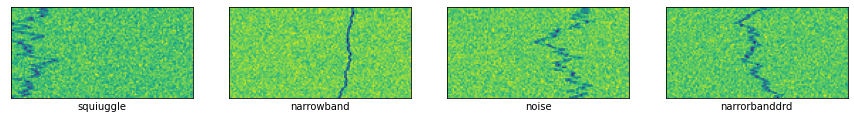

In [12]:
# classifers list
classifiers = ['squiuggle', 'narrowband', 'noise', 'narrorbanddrd']

# gets the 1st index of each type of class
def get_class_indices(class_id):
  return [i for i in range(y_train.shape[0]) if np.argmax(y_train[i])==class_id][0]

# collects the indices of 4 different kind of radio signals
indices = [get_class_indices(index) for index in range(len(classifiers))]
print('Sample images of the individual calss')
plt.figure(figsize=(15,15))
for i,index in enumerate(indices):
  plt.subplot(1,4,i+1)
  image = np.squeeze(x_train[i])
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(classifiers[i])

plt.show()


# Create Train and Validation data generators

Creating the train and validation datagenerator using keras ImageDataGenerator, and only horizontal_flip augmentation technique is used here, with batch_size = 64 for both train and validation set.

In [13]:
batch_size = 64

# Creating train generator object
train_datagen = IG(horizontal_flip=True, vertical_flip=True)

# Creating validation generator object
validation_datagen = IG(horizontal_flip=True, vertical_flip=True)

# Building the Convolution Neural Network model for classification

The architecture of the model consists of Conv2D layer, Relu(Rectifier Linear unit) activation, Batchnormalization, Maxpool layer(MaxPool2D). The architecture of the model consists of 


* **Convolution layer 1**
>  Filters = 32,
>
>  Batchnormalization,
>
>  Relu activation,
>
>  Maxpool layer
> 
>  Dropout(0.25)

* **Convolution layer 2**
>   Filters = 64,
>
>   Batchnormalization,
>
>   Relu activation,
>
>   Maxpool layer
> 
>  Dropout(0.25)

* **Flattening layer**

* **Fully connected layer**
> No of nodes = 1024, 
>
> Batchnormalization, 
>
> Relu Activation
> 
>  Dropout(0.40)

* **Output layer**
> No. of nodes = 4
>
> Softmax activation

For the entire network, 

* Across each Conv2D => Kernel size = (5,5)
* Across each MaxPool2D => Pool size = (2,2)
* Padding is same

In [16]:
# Initializing a Sequential CNN
CNN = Sequential()

# Convolution layer 1
CNN.add(Conv2D(32, (5,5), padding = 'same', input_shape = (64,128,1)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPool2D(2,2))
CNN.add(Dropout(0.25))

# Convolution layer 2
CNN.add(Conv2D(64, (5,5), padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(Dropout(0.25))

# Flattening
CNN.add(Flatten())

# Fully connected layer 1
CNN.add(Dense(1024))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(Dropout(0.4))

# Output layer
CNN.add(Dense(4, activation = 'softmax'))

print('Model summary:')
CNN.summary()

Model summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_3 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32,

# Learning rate scheduling and model compilation


Here a stepwise exponential decay of learning rate is being scheduled with it's inirtial value = 0.005. Here

1. Decay_steps = 5,
2. Decay_rate = 0.96

**learning_rate[ next ] = initial_learning_rate * decay_rate ^ (step / decay_steps)**

* **Model compiltion**
> Optimizer Adam(lr = Learning_rate_schedule)
>
> Loss = Categorical cross-entropy

In [18]:
initial_learning_rate = 0.005
# Declaring exponential-decay learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = initial_learning_rate,
                                                             decay_steps = 5,
                                                             decay_rate = 0.96,
                                                             staircase = True)

# Model compilation
CNN.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'categorical_crossentropy', metrics = ['acc'])

# Model training

> Epochs = 20
>
> Batch_size = 32

* PlotLossesCallback for live plot of model training
* ModelCheckpoint callback function is used to save the best model by monitoring minimum validation loss.

In [32]:
# callbacks

# Creating model library for recording model details
if not os.path.isdir('/content/Model'):
  os.mkdir('Model')

# Model checkpoint
mc = ModelCheckpoint('best_model.h5', monitor = 'val_loss', save_weights_only=True, mode = 'min', verbose = 1)

# PlotLossesCallback for live plot of model training
callbacks = [mc, PlotLossesCallback()]

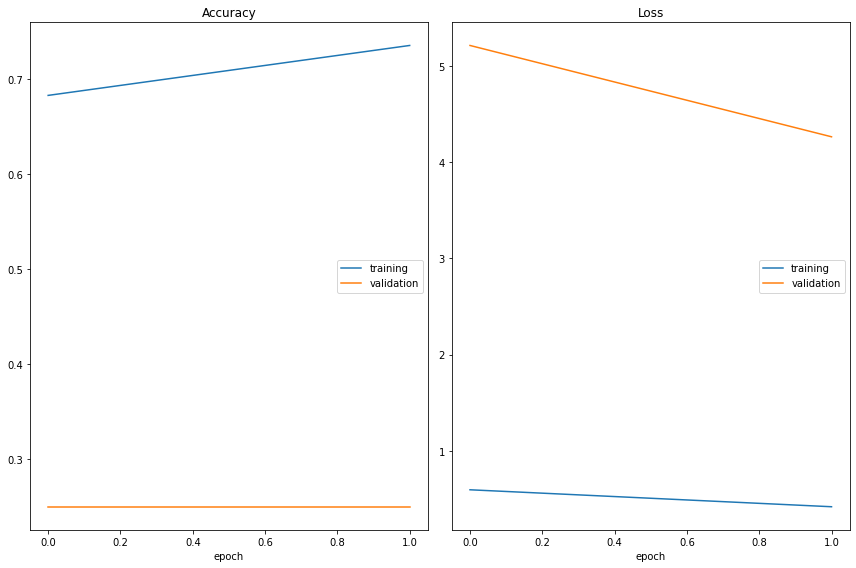

Accuracy
	training         	 (min:    0.683, max:    0.735, cur:    0.735)
	validation       	 (min:    0.250, max:    0.250, cur:    0.250)
Loss
	training         	 (min:    0.422, max:    0.598, cur:    0.422)
	validation       	 (min:    4.262, max:    5.210, cur:    4.262)
50/50 [==============================] - 180s 4s/step - loss: 0.4216 - acc: 0.7350 - val_loss: 4.2621 - val_acc: 0.2500


In [34]:
# Model training 
CNN.fit(train_datagen.flow(x_train,y_train, batch_size = batch_size, shuffle = True),
        epochs = 2,
        steps_per_epoch = len(x_train)//batch_size,
        validation_data = validation_datagen.flow(x_test, y_test, batch_size = batch_size, shuffle = True),
        callbacks = callbacks)

# Model Evaluation

In [41]:
loss, acc = CNN.evaluate(x_test, y_test)
print('Model classification \n\nloss: {0}\naccuracy: {1}'.format(loss, acc*100))

25/25 [==============================] - 10s 406ms/step - loss: 4.2621 - acc: 0.2500
Model classification 

loss: 4.262063503265381
accuracy: 25.0


Evaluating the result using **CONFUSION MATRIX** and heatmap using sklearn

In [52]:
y_true = np.argmax(y_test, 1)
y_pred = np.argmax(CNN.predict(x_test), 1)
print(metrics.classification_report(y_true, y_pred))
print('Classification Accuracy: %0.6f' % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.25      1.00      0.40       200
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00       200

    accuracy                           0.25       800
   macro avg       0.06      0.25      0.10       800
weighted avg       0.06      0.25      0.10       800

Classification Accuracy: 0.250000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


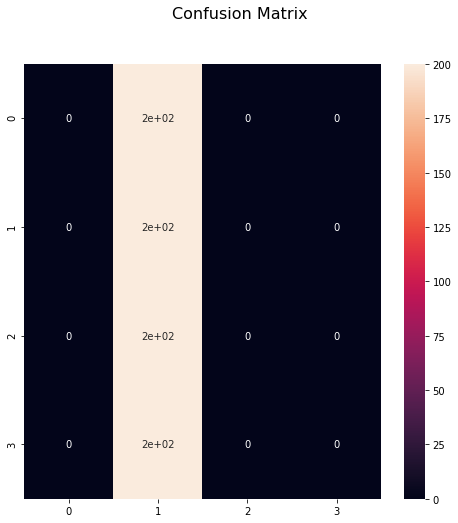

In [63]:
fig_cm = plt.figure(figsize=(8,8))
fig_cm.suptitle('Confusion Matrix', fontsize = 16)
# Annotation is considered to be True to annotate the cells
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
#plt.show to execute plt plot, else the matplotlib functional variable will be shown
plt.show()

# Prediction Samples Visualization

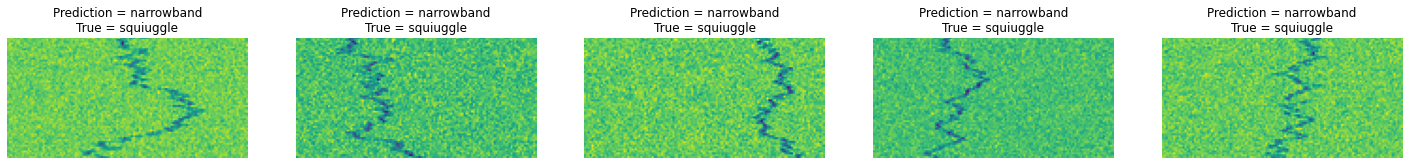

In [68]:
fig, axes = plt.subplots(1,5,figsize = (25,20))
for i in range(5):
  axes[i].imshow(np.squeeze(x_test[i]))
  axes[i].set_title('Prediction = {0}\nTrue = {1}'.format(classifiers[y_pred[i]], classifiers[y_true[i]]))
  axes[i].axis('off')